In [1]:
pip install -r requirements.txt


[notice] A new release of pip available: 22.2.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import imageio.v3 as iio
from PIL import Image
import numpy as np
from segmentation_models_pytorch.losses import JaccardLoss

/ext3/conda/dlproj/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import models as m
import utils as u

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


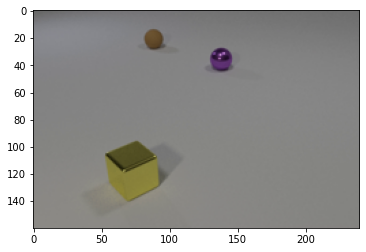

In [4]:
# look at the first image in the first video of the unlabeled data
plt.imshow(iio.imread('Dataset_Student/unlabeled/video_2000/image_0.png'))

In [5]:
# load in data from first 11 frames for each video

path = 'Dataset_Student/unlabeled/video_'
to_tensor = transforms.ToTensor()

data_x = []
for video in range(2000, 3000): # eventually use 15000
    # get the image path for each frame of each video
    img_path = path + str(video)
    video = []
    for frame in range(0, 11):
        fin_path = os.path.join(img_path, 'image_' + str(frame)+ '.png')
        # open image and convert to tensor
        img = Image.open(fin_path)
        img = to_tensor(img)
        video.append(img)
    video = torch.stack(video, dim=0)
    data_x.append(video)
data_x = torch.stack(data_x, dim=0)
data_x = data_x.reshape(data_x.size(0), data_x.size(1)*data_x.size(2), data_x.size(3), data_x.size(4))
print('Final Size of data_x tensor:', data_x.size()) # (number of videos, number of frames*color channels, image width, image height)

Final Size of data_x tensor: torch.Size([1000, 33, 160, 240])


In [6]:
# load in data from 22nd (last) frame for each video
data_y = []
for video in range(2000, 3000): # eventually use 15000
    # get the image path for the 22nd frame of each video
    img_path = path + str(video)
    fin_path = os.path.join(img_path, 'image_21.png')
    # open image and convert to tensor
    img = Image.open(fin_path)
    img = to_tensor(img).unsqueeze(0)
    data_y.append(img)
data_y = torch.stack(data_y, dim=0)
data_y = data_y.reshape(data_y.size(0), data_y.size(1)*data_y.size(2), data_y.size(3), data_y.size(4))
print('Final Size of data_y tensor:', data_y.size()) # (number of videos, number of frames*color channels, image width, image height)

Final Size of data_y tensor: torch.Size([1000, 3, 160, 240])


In [7]:
# batch size for training
batch_size = 32

# feed into dataloader
data = u.PretrainDataset(data_x, data_y)
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False)

In [ ]:
# set parameters for patch embeddings
image_size = (160, 240)
patch_size = 8
embed_dim = 256
expander_out = 512

model = m.VICReg(image_size, patch_size, embed_dim, expander_out=expander_out)

In [11]:
# forward pass model to test
import time

num_epochs = 2
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

t0 = time.time()
for epoch in range(num_epochs):
    model.train()
    epoch_loss = []

    for data in tqdm(dataloader, desc=f'epoch {epoch}'):
        x, y = data
        optimizer.zero_grad()
        loss = model(x, y)
        
        epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch} loss: {np.mean(epoch_loss)}')
    
print(f'Finished training in {(time.time()-t0)/60} minutes')
torch.save(model.state_dict(), "VICReg_pretrained.pth")

epoch 0: 100%|██████████| 32/32 [04:44<00:00,  8.91s/it]


Epoch 0 loss: 2.8701148703694344


epoch 1: 100%|██████████| 32/32 [04:45<00:00,  8.94s/it]


Epoch 1 loss: 0.7195268869400024
Finished training in 9.516506771246592 minutes


In [10]:
VICReg_model = m.VICReg(image_size, patch_size, embed_dim, expander_out=expander_out)
VICReg_model.load_state_dict(torch.load('VICReg_pretrained.pth'))
VICReg_model.eval()

VICReg(
  (patch_embed_x): PatchEmbedding(
    (proj): Conv2d(33, 256, kernel_size=(8, 8), stride=(8, 8))
  )
  (patch_embed_y): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(8, 8), stride=(8, 8))
  )
  (encoder_x): EmbedPosEncoding(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(33, 256, kernel_size=(8, 8), stride=(8, 8))
    )
  )
  (encoder_y): EmbedPosEncoding(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(3, 256, kernel_size=(8, 8), stride=(8, 8))
    )
  )
  (expander): Expander(
    (conv_transpose): ConvTranspose1d(600, 512, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (predictor): Predictor(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=153600, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Linear(in_features=1024, out_f

# This is where we start putting things together

In [16]:
class VideoPredictor(nn.Module):
    def __init__(self, VICReg):
        super().__init__()
        self.VICReg = VICReg
        self.MaskGenerator = MaskGeneration()
    
    def forward(self, x):
        s_x = self.VICReg.encoder_x(x)
        s_yhat = self.VICReg.predictor(s_x)
        s_yhat = torch.unsqueeze(s_yhat, dim=1)
        mask_pred = self.MaskGenerator(s_yhat)

        return mask_pred


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
        
    def __len__(self):
        return len(self.inputs)
        
    def __getitem__(self, idx):
        input_data = torch.tensor(self.inputs[idx], dtype=torch.float32)
        label_data = torch.tensor(self.labels[idx], dtype=torch.float32)
        return input_data, label_data


class MaskGeneration(nn.Module):
   def __init__(self): 
      super().__init__()
     
      self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
      
      self.conv2 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=49, kernel_size=3, padding=1, stride = 2), #48 classes (objects) + 1 background
          nn.BatchNorm2d(49),
          nn.ReLU(),
      )
      
   def forward(self, x, verbose=False):
      x1 = self.conv1(x)
      x2 = self.conv2(x1)
      conv_final = x2.view(x2.shape[0], 49, 160, 240)  # (N, C, H, W)      
      return conv_final
   

class VideoPredictionDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
        
    def __len__(self):
        return len(self.inputs)
        
    def __getitem__(self, idx):
        input_data = self.inputs[idx]
        label_data = self.labels[idx].to(torch.int64)
        return input_data, label_data


NameError: name 'list_video_paths' is not defined

In [20]:
train_folder = "Dataset_Student/train/"
val_folder = "Dataset_Student/val/"

def create_finetune_dataloader(folder, image_size, batch_size):

  to_tensor = transforms.ToTensor()
  list_video_paths = [folder + v for v in os.listdir(folder)]

  data_y = torch.empty(len(list_video_paths), image_size[0], image_size[1]) # 22nd segmentation mask for each video (B, H, W)
  data_x = torch.empty(len(list_video_paths), 11, 3, image_size[0], image_size[1]) # first 11 frames of each video (B, n_frames, C, H, W)

  i = 0
  for video_path in tqdm(list_video_paths, desc='creating data_x and data_y'):
    last_mask = torch.Tensor(np.load(f"{video_path}/mask.npy"))[-1]
    last_mask[last_mask>48] = 0
    data_y[i] = last_mask

    for frame in range(0, 11):
      fin_path = os.path.join(video_path, 'image_' + str(frame)+ '.png')
      img = Image.open(fin_path)
      img = to_tensor(img)
      data_x[i][frame] = img

    i += 1
  
  data_x = data_x.reshape(data_x.size(0), data_x.size(1)*data_x.size(2), data_x.size(3), data_x.size(4))
  video_prediction_data = VideoPredictionDataset(data_x, data_y)
  video_prediction_dataloader = torch.utils.data.DataLoader(video_prediction_data, batch_size=batch_size, shuffle=True)

  return video_prediction_dataloader

print('Creating Train Dataloader:')
video_prediction_trainloader = create_finetune_dataloader(train_folder, image_size, batch_size)
print('Creating Val Dataloader:')
video_prediction_valloader = create_finetune_dataloader(val_folder, image_size, batch_size)

Creating Train Dataloader:


creating data_x and data_y: 100%|██████████| 1000/1000 [00:17<00:00, 58.10it/s]


Creating Val Dataloader


creating data_x and data_y: 100%|██████████| 1000/1000 [00:17<00:00, 58.25it/s]


In [21]:
# set parameters for patch embeddings
image_size = (160, 240)
video_prediction_model = VideoPredictor(VICReg_model)

num_epochs = 2
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = JaccardLoss(mode ='multiclass')

train_losses = []
val_losses = []
for epoch in range(num_epochs):
    video_prediction_model.train()
    epoch_train_loss = []
    epoch_val_loss = []

    for data in tqdm(video_prediction_trainloader, desc=f'epoch {epoch}'):
        x_train, y_train = data
        x_train.to(device)
        y_train.to(device)
        optimizer.zero_grad()
        y_train_pred = video_prediction_model(x_train)
        loss = criterion(y_train_pred, y_train)
        
        epoch_train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    epoch_train_loss_mean = np.mean(epoch_train_loss)
    print(f'Epoch {epoch} train loss: {np.mean(epoch_train_loss)}')
    train_losses.append(epoch_train_loss_mean)

    with torch.no_grad():
        for data in video_prediction_valloader:
            x_val, y_val = data  # batch_size, num_channels = 3, image_size
            x_val.to(device)
            y_val.to(device)
            y_val_pred = video_prediction_model(x_val)

            #input to the model should be patch_embeddings learned during pretraining
            loss = criterion(y_val_pred, y_val)
            epoch_val_loss.append(loss.item())
        
        epoch_val_loss_mean = np.mean(epoch_val_loss)
        print(f'Epoch {epoch} val loss: {np.mean(epoch_val_loss)}')
        val_losses.append(epoch_val_loss_mean)


epoch 0: 100%|██████████| 32/32 [01:26<00:00,  2.71s/it]


Epoch 0 train loss: 0.9526102170348167
Epoch 0 val loss: 0.9564250186085701


epoch 1: 100%|██████████| 32/32 [01:31<00:00,  2.86s/it]


Epoch 1 train loss: 0.9538844712078571
Epoch 1 val loss: 0.9602553118020296


In [26]:
import time
print(f'test_{round(time.time())}')


test_1682388103
